In [2]:
import numpy as np
import robotic as ry
import matplotlib.pyplot as plt

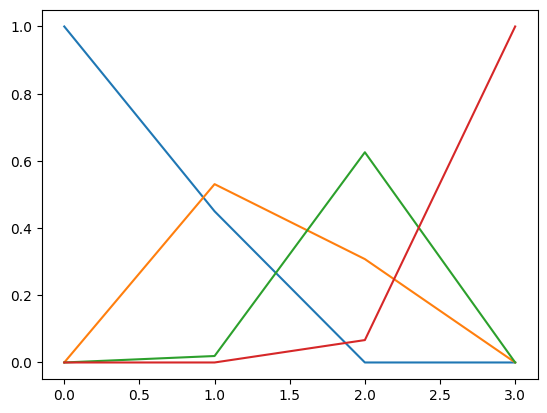

STACK9 /bin/python3(_PyEval_EvalFrameDefault
STACK8 /bin/python3() [0x5d39dc]
STACK7 /bin/python3(PyEval_EvalCode
STACK6 /bin/python3(_PyEval_EvalFrameDefault
STACK5 /bin/python3(_PyObject_MakeTpCall
STACK4 /bin/python3() [0x58238f]
STACK3 /home/denis/.local/lib/python3.12/site-packages/robotic/_robotic.so(+0x3f9c5) [0x79cbb3f209c5]
STACK2 /home/denis/.local/lib/python3.12/site-packages/robotic/_robotic.so(+0x9f887) [0x79cbb3f80887]
STACK1 rai::BSpline::setCtrlPoints(rai::ArrayDouble const&, bool, bool, rai::ArrayDouble const&, rai::ArrayDouble const&)
STACK0 rai::LogToken::~LogToken()


== ERROR:spline.cpp:setCtrlPoints:143(-2) CHECK_EQ failed: 'ctrlPoints.d0'=5 'knots.N-degree-1'=6 -- 


RuntimeError: spline.cpp:setCtrlPoints:143(-2) CHECK_EQ failed: 'ctrlPoints.d0'=5 'knots.N-degree-1'=6 -- 

In [ ]:
S = ry.BSpline()
S.setKnots(2, [0, 10, 40, 100])
B = S.getBmatrix(np.linspace(0.,100.,100))

plt.plot(B)
plt.show()

X = np.random.randn(3, 1)
S.setCtrlPoints(X)
x = S.eval(np.linspace(-.1,1.1,100))
v = S.eval(np.linspace(-.1,1.1,100), 1)
a = S.eval(np.linspace(-.1,1.1,100), 2)

plt.plot(np.hstack((x,v/10.,a/100.)))
plt.show()

plt.plot(x)
plt.scatter(np.linspace(0, 100, 10), X.squeeze(1), color="r")
plt.show()

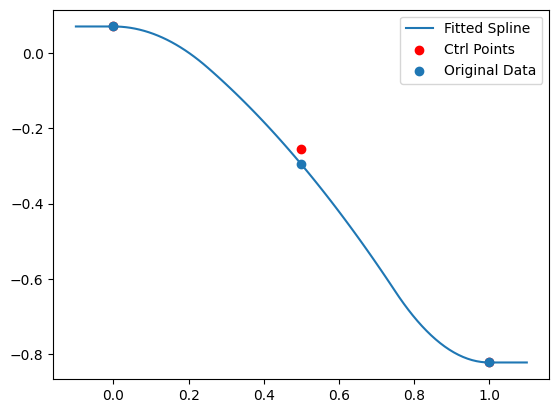

In [15]:
path_duration = 1.
equidistant_knots = np.linspace(0.,path_duration,3)
degree = 2
data = np.random.randn(3)

S = ry.BSpline()
S.setKnots(degree, equidistant_knots)
B = S.getBmatrix(np.linspace(0., path_duration, 3))

ctrl_pts = np.linalg.inv(B) @ data
S.setCtrlPoints(ctrl_pts.reshape(3, 1))

T = [-.1*path_duration, 1.1*path_duration]
ts = np.linspace(*T, 100)
x = S.eval(ts)

plt.plot(ts, x, label="Fitted Spline")

ts = np.linspace(0, path_duration, 3)
plt.scatter(ts, ctrl_pts, color="r", label="Ctrl Points")
plt.scatter(ts, data, label="Original Data")
plt.legend()
plt.show()

(128,)
(128,)


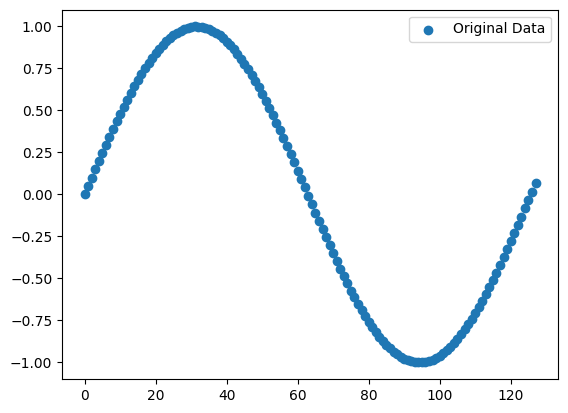

In [16]:
path_len = 128
data_x = np.linspace(0, path_len-1, path_len)
data_y = np.sin(data_x*.05) + np.random.randn(path_len) * .0
print(data_x.shape)
print(data_y.shape)
plt.scatter(data_x, data_y, label="Original Data")
plt.legend()
plt.show()

In [17]:
def fit_splines(path: np.ndarray, error_threshold: float=.5, degree: int=2, knots: int=3):
    # Init variables
    start_idx = 0
    end_idx = len(path)
    splines = [] # Each spline has 3 control points and a length

    while True:
        
        # Prepare Path
        to_be_fitted_full = path[start_idx:end_idx]
        indices = np.round(np.linspace(0, len(to_be_fitted_full)-1, knots).astype(int))
        to_be_fitted_slice = to_be_fitted_full[indices]

        # Setup Knots
        S = ry.BSpline()
        
        equidistant_knots = np.linspace(start_idx, end_idx-1, knots)
        S.setKnots(degree, equidistant_knots)
        
        # Fit spline
        B = S.getBmatrix(np.linspace(start_idx, end_idx-1, knots))
        ctrl_pts = np.linalg.inv(B) @ to_be_fitted_slice
        S.setCtrlPoints(ctrl_pts.reshape(knots, 1))

        # Calculate error
        ts = np.linspace(start_idx, end_idx-1, len(to_be_fitted_full))
        prediction = S.eval(ts)
        max_error = np.max(np.abs(to_be_fitted_full - prediction))

        if max_error < error_threshold:
            # Add spline
            start_idx = end_idx-1
            splines.append([ctrl_pts, len(to_be_fitted_full)])
            
            # Break condition
            if end_idx == len(path):
                break
            end_idx = len(path)
        else:
            # Recompute spline with new end point
            end_idx -= 1
        

    return splines

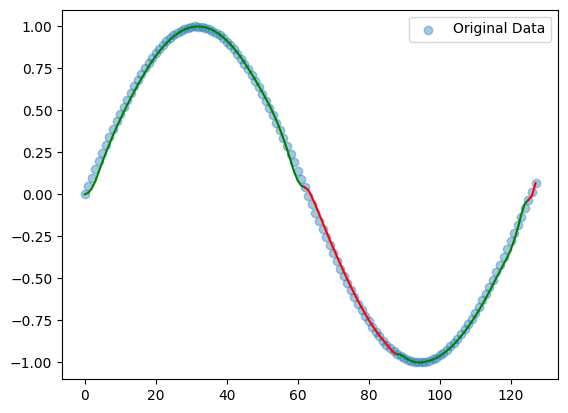

In [18]:
degree = 2
knots = 10
splines = fit_splines(data_y, error_threshold=1, degree=degree, knots=knots)
plt.scatter(data_x, data_y, alpha=.4, label="Original Data")

current_pos = 0
for i, s in enumerate(splines):

    start = current_pos
    end = current_pos + s[1]-1

    S = ry.BSpline()
    
    equidistant_knots = np.linspace(start, end, knots)
    S.setKnots(degree, equidistant_knots)
    S.setCtrlPoints(s[0].reshape(knots, 1))

    x = np.linspace(start, end, s[1])
    y = S.eval(x)
    
    color = "r" if i%2 else "g"
    plt.plot(x, y, color=color)
    current_pos += s[1]-1

plt.legend()
plt.show()